![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Automatic Ticket Assignment

### This is an interim report. This is describing our approach how are we proceeding on the give problem.

### Also in preprocessing,we are working on reducing data imbalance. progressed work is not included in this project yet. 

### We are still working on improving accuracy of models.


### Summary of problem statement.
In any IT industry, Incident Management plays an important role in delivering quality support to customers. An incident ticket is created by various groups of people within the organization to resolve an issue as quickly as possible based on its severity. Whenever an incident is created, it reaches the Service desk team and then it gets assigned to the respective teams to work on the incident.

The Service Desk team (L1/L2) will perform basic analysis on the user's requirement, identify the issue based on given descriptions and assign it to the respective teams.
The manual assignment of these incidents might have below disadvantages:
- More resource usage and expenses
- Human errors - incidents get assigned to the wrong assignment groups
- Delay in assigning the tickets
- More resolution times
- If a particular ticket takes more time in analysis, other productive tasks get affected for the service desk
If this ticket assignment is automated, it can lower resolution time and be more cost-effective, enabling the service desk team to focus on other productive tasks.

**Required Files given in below link.**
https://drive.google.com/file/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ/view

In [50]:
#All packages used in this project
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.constraints import maxnorm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV,GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten,Input,SpatialDropout1D,LSTM,TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import PredefinedSplit
from gensim.models import KeyedVectors #word2vec
import os.path
from os import path
from dateutil import parser
import re

from io import BytesIO
from zipfile import ZipFile
import requests

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
import time

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

!pip install -q googletrans
!pip install -q spacy 
!pip install pyspellchecker

import spacy
from googletrans import Translator
from nltk.corpus import stopwords
import nltk
from spellchecker import SpellChecker

nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

print('tensorflow version ',tf.__version__)
print('pandas version ',pd.__version__)
print('numpy version ',np.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
tensorflow version  2.3.0
pandas version  1.1.4
numpy version  1.18.5


In [51]:
#Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
#let's find the current working directory
!pwd

/content/drive/My Drive/Colab Notebooks/NLP-AutomaticTicketAssignment


In [53]:
#change working directory to project folder.
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP-AutomaticTicketAssignment/')

In [54]:
#list the directory
!ls

'Automatic Ticket Assignment Brief.pdf'   input_data.xlsx   model.bin   README
 AutomaticTicketAssignment.ipynb	  meta.json	    model.txt


In [55]:
#Set current directory data dir
data_dir = './'

Load XLS file using XLSLoader class into DataFrame. and check details (missing values, datatype and count etc..) of input data.


In [56]:
#Class to load xls file
class XlsLoader :
  _filePath = ""
  _xlsDF = pd.DataFrame()

  def __init__(self, filePath):
    self._filePath = filePath
 
  def load_data(self):
      print("loading file {}".format(self._filePath))
      self._xlsDF = pd.read_excel(self._filePath)

  def dropField(droppedFieldName):
    return self._xlsDF.drop([droppedFieldName],axis=1)    

  def groupBy(self,columnName):
      df = self._xlsDF.groupby([columnName]).count()
      print(df)



In [57]:
#read input file from xls 
filePath = data_dir + "input_data.xlsx"
loader = XlsLoader(filePath)
loader.load_data()

loading file ./input_data.xlsx


In [58]:
loader._xlsDF.columns = ['shortdescription', 'description', 'caller', 'assignmentgroup']

In [59]:
#header of inputs
loader._xlsDF.head(5)

,shortdescription,description,caller,assignmentgroup
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [60]:
#info of input data
loader._xlsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   shortdescription  8492 non-null   object
 1   description       8499 non-null   object
 2   caller            8500 non-null   object
 3   assignmentgroup   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [61]:
#data types of data frame columns
loader._xlsDF.dtypes

shortdescription    object
description         object
caller              object
assignmentgroup     object
dtype: object

In [62]:
#fill N/A with "##"" characters.
loader._xlsDF = loader._xlsDF.fillna("#")

In [63]:
#Info explains that there is no missing value in input dataframe.
loader._xlsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   shortdescription  8500 non-null   object
 1   description       8500 non-null   object
 2   caller            8500 non-null   object
 3   assignmentgroup   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [64]:
#let check the number of groups (output)
loader._xlsDF.assignmentgroup.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_73       1
GRP_70       1
GRP_64       1
GRP_35       1
GRP_67       1
Name: assignmentgroup, Length: 74, dtype: int64

In [65]:
#concat short description and description field. 
loader._xlsDF['sdesc_desc'] = loader._xlsDF['shortdescription'].astype('string') + " " + loader._xlsDF['description'].astype('string')  

In [66]:
#check the output of sdesc_desc column is string.
loader._xlsDF.dtypes

shortdescription    object
description         object
caller              object
assignmentgroup     object
sdesc_desc          string
dtype: object

In [67]:
#Adding num_words column having the lenght of sdesc_desc column
loader._xlsDF['num_words'] = loader._xlsDF.sdesc_desc.apply(lambda x : len( x.split() ))

In [68]:
#head 5 elements of input data
loader._xlsDF.head(5)

,shortdescription,description,caller,assignmentgroup,sdesc_desc,num_words
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...,35
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook received from: hmjdrvpb.komuaywn@g...,26
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn received from: eylqgodm...,16
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page unable to access...,10
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,4


#Pre-Processing, Data Visualization and EDA
 - Exploring the given Data files
 - Understanding the structure of data
 - Missing points in data
 - Finding inconsistencies in the data
 - Visualizing different patterns
 - Visualizing different text features
 - Dealing with missing values
 - Text preprocessing
 - Creating word vocabulary from the corpus of report text data
 - Creating tokens as required

In [69]:
#Plotter class responsible to provide all visual plots
class Plotter :
   _xlsDF = pd.DataFrame()
   
   def __init__(self,df):
    self._xlsDF = df.copy()

   def bar_plot(self, bins , labels):
     plt.figure(figsize=(10,6))
     df = self._xlsDF
     df['bins'] = pd.cut(df.num_words, bins, labels)
     word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})
     sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

   def count_plot(self,title,columnName):
     plt.figure(figsize=(10,6))
     ax = sns.countplot(x=columnName, data=self._xlsDF)
     plt.title(title)

   def bar_plot_groupby(self, groupby, numwords):
     word_avg = self._xlsDF.groupby(groupby)[numwords].mean().plot(kind='bar', figsize=(25,15))
     plt.xlabel('desc', fontsize=20)
     plt.ylabel('Count of Words', fontsize=20)
     plt.xticks(fontsize=20)
     plt.yticks(fontsize=20)
     plt.title('Number of Words per Description Distribution', fontsize=30)
     plt.show()

   def word_cloud_plot(self, allwordsSeris, word_count):
     allwords = []
     for series in allwordsSeris:
       for word in series:
         allwords.append(word)         
     mostcommon = FreqDist(allwords).most_common(word_count)
     wordcloud = WordCloud(width=800, height=600, background_color='white').generate(str(mostcommon))
     fig = plt.figure(figsize=(20,10), facecolor='white')
     plt.imshow(wordcloud, interpolation="bilinear")
     plt.axis('off')
     plt.title('Top '+str(word_count)+' Most Common Words', fontsize=30)
     plt.tight_layout(pad=0)
     plt.show()

   def heat_map_plot_review_len_word_len(self ):
     loader._xlsDF['review_len'] = loader._xlsDF['sdesc_desc'].str.len()
     correlation = loader._xlsDF[['review_len','num_words']].corr()
     mask = np.zeros_like(correlation, dtype=np.bool)
     mask[np.triu_indices_from(mask)] = True
     plt.figure(figsize=(8,6))
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 15}, linewidths=10, vmin=-1.5, mask=mask)
   
   def draw_cm_matrix(self,cmdict,rows, columns):
     pos = 1
     plt.figure(figsize = (16,8))
     for key in cmdict.keys() :
       cm = cmdict.get(key)
       plt.subplot(rows, columns, pos)   # plot grid
       df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
       ax = sns.heatmap(df_cm,center=0.5, cmap= 'coolwarm', annot=True ,fmt='g', linewidths=1)
       plt.xticks(fontsize=14)
       plt.yticks(fontsize=14)
       plt.title(key)
       pos += 1  

   def writ_metrics_cm(self, cmdict):
     cmResult = pd.DataFrame(columns=['Method', 'recall', 'precison', 'specificity', 'f1_score'])
     for key in cmdict.keys() :
       cm = cmdict.get(key)
       tn, fp, fn, tp = cm.ravel()  # compute the confusion matrix from the predictions and actuals
       recall = round(tp/(tp+fn), 3)   
       precision = round(tp/(tp+fp), 3)  
       specificity =round(tn/(tn+fp),3) 
       f1_score =  round(2*precision*recall/(precision + recall), 3)
       cmResult = cmResult.append({'Method': key, 'recall': recall, 'precison': precision,'specificity':specificity,'f1_score':f1_score}, 
                                   ignore_index=True)
     return cmResult    

   def draw_line_chart(self,df,title, xlabel, ylabels):
     for ylabel in ylabels:
       plt.plot(df[xlabel], df[ylabel], marker='o', label= ylabel)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.xticks(rotation=45, ha='right')
     plt.legend("lower left")
     plt.ylabel('Statistics')
     plt.show()


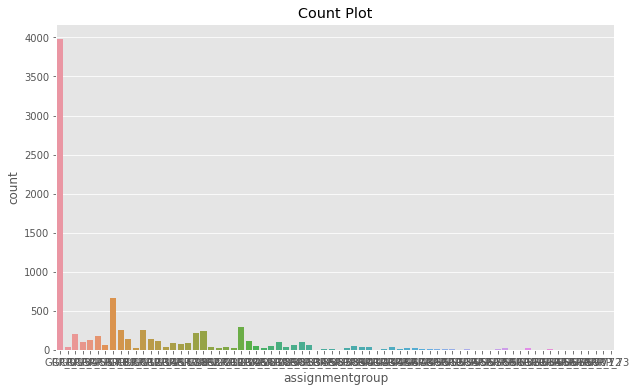

In [70]:
#draw the count plot to understand the data distrubution accross the groups.
plotter = Plotter(loader._xlsDF)
plotter.count_plot("Count Plot","assignmentgroup")

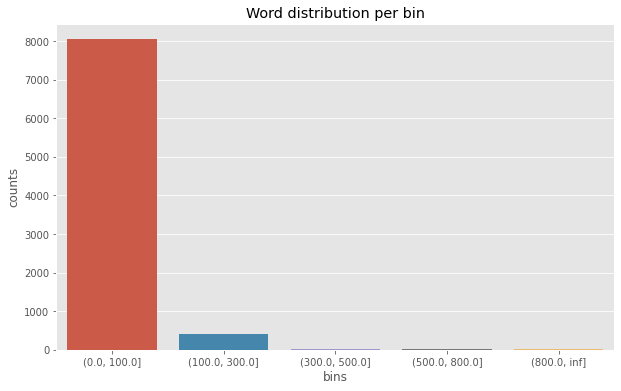

In [71]:
#Bins to explain the lenght distribution of descriptions. there huge number of messages having description lenght less than 100. 
plotter.bar_plot(bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

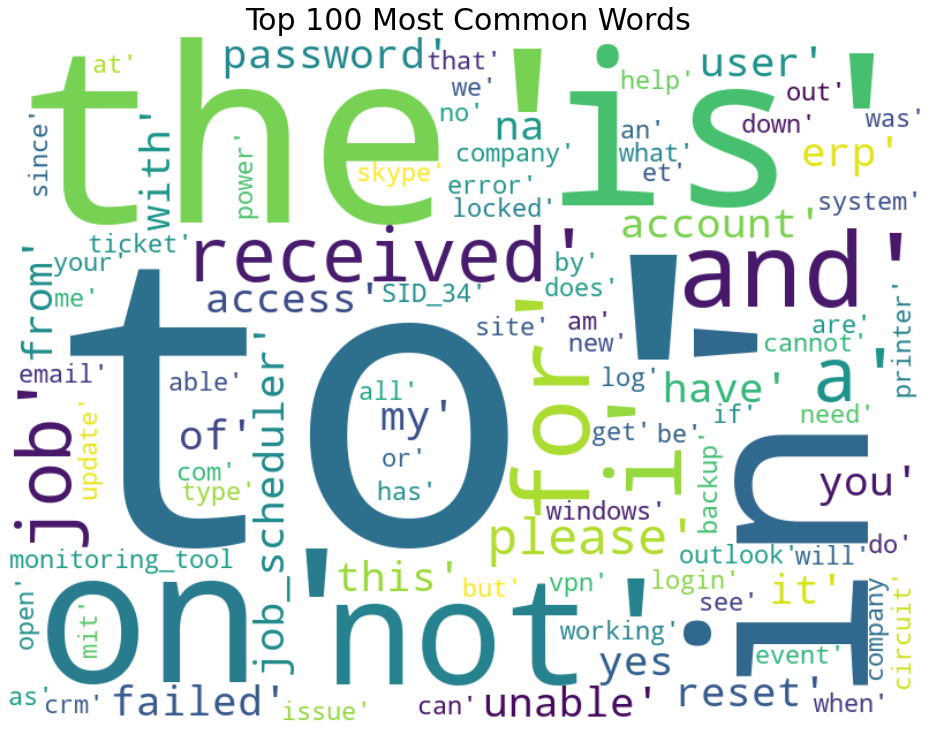

In [72]:
#lets draw word cloud to find the higher frequency words.
allwordsSeris = loader._xlsDF['sdesc_desc'].str.split()
plotter.word_cloud_plot(allwordsSeris,100)

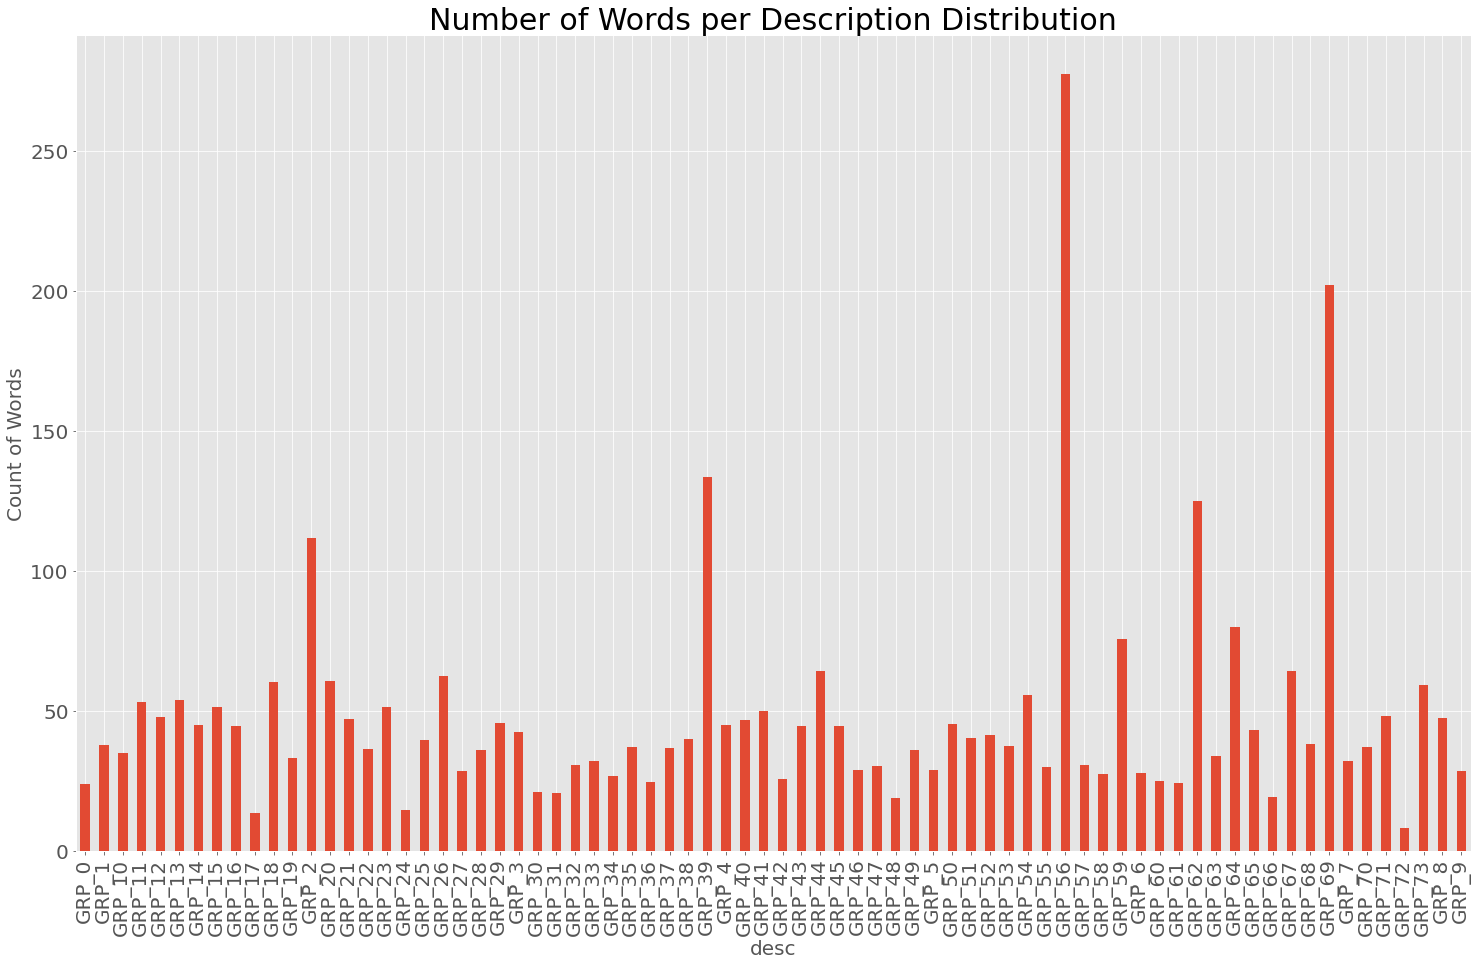

In [73]:
#bar plot to words per group. group 56 has maximum number of words among all groups.
plotter.bar_plot_groupby('assignmentgroup','num_words')

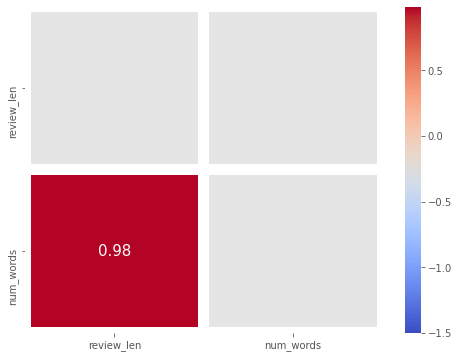

In [74]:
#heat map to understand the co-releation between number of words and review lenght.
plotter.heat_map_plot_review_len_word_len()

In [75]:
#Utility class providing utitly functions
class Utility :  
  def currtime(self): #provide current time in milisec
    return int(round(time.time() * 1000))

  def download_and_unzip(self, url): #download and unzip file from give url.
    content = requests.get(url)
    zf = ZipFile(BytesIO(content.content))
    zf.extractall()
    for item in zf.namelist():
      print("File in zip: "+  item)

In [76]:
class Preprossesing:   #Preprocessing class responsbile to preprocess the input data.
  def __init__(self,df, xColName, yColName, randonmState = 42):
    self._xlsDF = df
    self._random = randonmState
    self._xColName = xColName
    self._yColName = yColName
    self.X_Data = self._xlsDF[self._xColName]
    self.y_Data = self._xlsDF[self._yColName]
    self.nlp = spacy.load('en', disable=['parser', 'ner'])
    self.allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    self.index = 0
    self.total_time = 0
    self.spell = SpellChecker()
    self.spell.word_frequency.load_words(['netweaver','-pron-','caas','hostname','unmonitored','activesync','audiocode','isp','apac','skype','callie','worklist','gsc','verizon',
                                      'firewall','wifi','downloader','uploaded','crm','mms','iphone','rgds','thx','inbox','prefetch','mbps','website','www','inplant','openstage',
                                      'costcenter','undeliverable','svC','emea','html','reinstall','upload','jpg','signout','malware','cvss','rar','xls','uplink','ziped','uncaught',
                                      'xlsx','wlan','webpage','uploader','firefox','callback','acct','abap','svchost','webserviceclient','wlc','sid'])
 

  def split(self,testsize): #spilt function providing train and test split on give size.
    print('spitting data on x column name {}, y column name {}, testsize {}'.format(self._xColName, self._yColName, str(testsize)))
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_Data, self.y_onhot_encoded, test_size=testsize, random_state=self._random)
    print("Train Data type X_train: {}, len X_train: {}, type y_train {}, len y_train {}".format(type(self.X_train) ,len(self.X_train),type(self.y_train) ,len(self.y_train)))
    print("Test Data type X_test: {}, len X_test: {}, type y_test{}, len y_test {}".format(type(self.X_test),len(self.X_test),type(self.y_test) ,len(self.y_test)))
  
  def encode_labels(self): #encode output labels from string to integer. 
    self.X_Data = self.X_Data.str.lower()
    encoder = LabelEncoder()
    encoder.fit(self.y_Data)
    self.y_onhot_encoded = encoder.transform(self.y_Data)
    #self.y_onhot_encoded = np_utils.to_categorical(self.y_Data_encoded)

  def is_valid_date_internal(self, date_str): #parsing dates
    try:
        parser.parse(date_str)
        return True
    except:
        return False

  def clean_data_internal(self, text): # function to clean the give text
    text=text.lower()
    text = ' '.join([w for w in text.split() if not self.is_valid_date_internal(w)])
    #there are many mails in description. email body is not needed. We just need details lets remove them.
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    
    #& 
    text = re.sub(r'&;?', 'and',text)

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in self.callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')

    text = re.sub(r"\s+[a-zA-Z]\s+", '', text)   
    text = re.sub(' +', '', text)

    #Remove all words lesser than size of 2. English words less than 2 size doesn't make sense
    text = ' '.join([w for w in text.split() if len(w)>2])
    
    #strip the text
    text = text.strip()
    return text

  def lemmatize_text_internal(self,text): #lematization of provide text
    doc = self.nlp(text)
    return ' '.join([token.lemma_ for token in doc])

  def spell_check_internal(self, text): #do spell check
    wordlist = [word for word in text.split()]
    misspelled = self.spell.unknown(wordlist)
    for incorrect in misspelled:
      correct = self.spell.correction(incorrect)
      text = text.replace(incorrect, correct)
    return text

  def translate_to_english_internal(self, x): #traslate words to english if other language words exist in description.
    translator = Translator()
    if translator.detect(x).lang != 'en':
        translatedText = translator.translate(x).text
    else:
        translatedText = x
    return translatedText

  def preprocess_data_internal(self, x): #funtion to apply all preprocess steps.
    utility = Utility()
    self.index = self.index+1
    start = utility.currtime()
    x = self.clean_data_internal(x)
    x = x.lower()
    x = self.lemmatize_text_internal(x)
#    x = self.spell_check_internal(x)           #Need to improve spell check taking lot of time now.
#    x = self.translate_to_english_internal(x)  #Need to improve taking lot of time.
    self.total_time = self.total_time + ( utility.currtime() - start ) 
    if self.index == 1000 :
      self.index = 0
      print("preprocessing  1000 text done. time take : {} min".format(self.total_time/60000))
      self.total_time = 0
    return x

  def preprocess_data(self, callers):
    self.callers = callers
    self.X_Data.apply(self.preprocess_data_internal)

In [77]:
SPLIT_SIZE = 0.05 #let take only 5% of data in validation 
preprocess = Preprossesing(loader._xlsDF, 'sdesc_desc', 'assignmentgroup')

#Do Data preprocessing.
callers = loader._xlsDF['caller'].unique() 
preprocess.preprocess_data(callers)

preprocessing  1000 text done. time take : 0.10751666666666666 min
preprocessing  1000 text done. time take : 0.10571666666666667 min
preprocessing  1000 text done. time take : 0.10473333333333333 min
preprocessing  1000 text done. time take : 0.13253333333333334 min
preprocessing  1000 text done. time take : 0.11795 min
preprocessing  1000 text done. time take : 0.11766666666666667 min
preprocessing  1000 text done. time take : 0.10981666666666667 min
preprocessing  1000 text done. time take : 0.1827 min


In [78]:
#encode lables and split size.
preprocess.encode_labels()
preprocess.split(SPLIT_SIZE)

spitting data on x column name sdesc_desc, y column name assignmentgroup, testsize 0.05
Train Data type X_train: <class 'pandas.core.series.Series'>, len X_train: 8075, type y_train <class 'numpy.ndarray'>, len y_train 8075
Test Data type X_test: <class 'pandas.core.series.Series'>, len X_test: 425, type y_test<class 'numpy.ndarray'>, len y_test 425


#Model Building
 - Building a model architecture which can classify.
 - Trying different model architectures by researching state of the art for similar tasks.
 -  Train the model
 - To deal with large training time, save the weights so that you can use them when training the
model for the second time without starting from scratch.

Approach:
- Apply SVC, RandomForest, LogisticRegression and NN Models.
- Create Pipelines for give models and Run in preproessed data. Pipeline include tokenization add PaddingSequence and Model training.
- Use RandomizedCV is used to do cross validation on Pipeline.
- Collect result in DFResult and compute confusion matrix of individual model.
- Compare accuracy and time consumend of training and test results. 

In [79]:
#Scikit-learn provides two classes, BaseEstimator and TransformerMixin to easily implement our custom transformers.

#tokenizer to use in pipeline.
class TokenizerTransformer(BaseEstimator, TransformerMixin, Tokenizer):
    def __init__(self,**tokenizer_params):
        Tokenizer.__init__(self, **tokenizer_params)

    def fit(self, X, y=None):
        self.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        X_transformed = self.texts_to_sequences(X)
        return X_transformed


In [80]:
#Padding sequence to use in pipeline.
class PadSequencesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_sentence_len, padding_type, trunc_type):
        self.max_sentence_len = max_sentence_len
        self.padding_type = padding_type
        self.trunc_type = trunc_type

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_padded =pad_sequences(X, maxlen=self.max_sentence_len, padding=self.padding_type, truncating=self.trunc_type)
        return X_padded

In [81]:
#Embdding matrix class. responsible to downlad embedding from given URL and provide emebeddings.
class EmbeddingMatrix : 
  def __init__(self,  tokenizer):
    self.tokenizer = tokenizer

  def load_word2Vec_300size(self) :
    utility = Utility()
    start = utility.currtime()
    fileName = "model.txt"
    print("Loading word2vec embedding start {}".format(fileName ))
    
    if path.exists(fileName) == False :
      utility.download_and_unzip("http://vectors.nlpl.eu/repository/20/8.zip")
    embeddings = {}
    for o in open(fileName):
       word = o.split(" ")[0]
       embd = o.split(" ")[1:]
       embd = np.asarray(embd, dtype='float32')
       embeddings[word.lower()] = embd
    print("loading word2vec emebdding done." + str(len(embeddings)) + " words loaded!. time : {} milisec".format(utility.currtime() - start))
    return embeddings
 
  def load_embeddedings(self, emebdddingName ) :
    embedded_dim = 300
    if emebdddingName in EMBEDDING_MATRIX :
      embedding_matrix = EMBEDDING_MATRIX.get(emebdddingName)
      return embedding_matrix, len(embedding_matrix[0]), len(embedding_matrix)

    embeddings =  None 
    if emebdddingName == 'word2vec':
      embeddings = self.load_word2Vec_300size()
    
    utility = Utility()
    start = utility.currtime()
    vocabsize = len(self.tokenizer.word_index)+1
    embedding_matrix = np.zeros((vocabsize,embedded_dim))
    notfound = 0
    for word, i in self.tokenizer.word_index.items():
      embedding_vector = embeddings.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
      else :
        notfound = notfound+1  

    print("Embedding matrix creation Done. time : {} milisec embedding_matrix shape: {} vocab_size: {} notfound {}".format((utility.currtime() - start), embedding_matrix.shape, vocabsize, notfound))
    EMBEDDING_MATRIX[emebdddingName] = embedding_matrix
    return embedding_matrix, embedded_dim ,vocabsize


In [82]:
#GLOABL PARAMS
SENTENCE_LEN = 32
PADDING_TYPE = 'post'
TRUNCATE_TYPE = 'post'
EPOCHS = 100
BATCH_SIZE = 200
VERBOSE = 1
PATIENCE = 5

SPATIAL_DROPOUT =  0.2
DROPOUT = 0.2
RECURRENT_DROPOUT= 0.2

In [83]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

#NNModels class to provide NN Models.
class NNModels :   
  def __init__(self,tokenizer):
    self.embedding = EmbeddingMatrix(tokenizer)

  def create_nn_embeddings_lstm_model(self, embeddingName, activation):
    embeddings_matrix, embeddings_dim, vocabsize =  self.embedding.load_embeddedings(embeddingName)

    model = Sequential()
    model.add(Input(shape=(SENTENCE_LEN,)))
    model.add(Embedding(vocabsize, embeddings_dim,
                            input_length=SENTENCE_LEN,
                            weights=[embeddings_matrix],                            
                            trainable=False))                                                       
    model.add(SpatialDropout1D(SPATIAL_DROPOUT)) 
    model.add(LSTM(embeddings_dim,activation=activation, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, return_sequences=True ))
    model.add(LSTM(1000,activation=activation, return_sequences=True))
    model.add(Dense(256, activation = activation)) 
    model.add(Dropout(DROPOUT))                                          
    model.add(Dense(128, activation = activation))                                           
    model.add(Dense(100, activation=activation))
    model.add(Flatten())
    model.add(Dense(74, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [84]:
#checkpoint and earlystopping and ReducLROnPlateau to avoid overfitting in NN
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=False,
                             save_weights_only=False, mode="min")

stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.00002, patience=PATIENCE, min_lr=1e-6, verbose=0, mode="min")

In [85]:

EMBEDDING_MATRIX = {} #Embdedded matrix dictionary helping to redue the time of excuting pipeline.

#Parent Pipeline class. Inherited by ModelPipeline classes.
class ModelPipeline:
  #Model Name. definition is provided by child Model pipeline classes
  def getName(self):
    pass
  
  #Mode Hyper parameters. Provided by child Model pipeline classes.
  def getModelParam(self):
    pass

  #Create Pipeline. Defintion is provided by child classes. 
  def createPipeline(self):
    pass

  #Callbacks to add in fit params.
  def getCallbacks(self):
    pass

  #Pipeline fit function. Used by all child clasess.
  def fit_pipeline(self, X_train, y_train):
    model_param = self.getModelParam()
    callbacks = self.getCallbacks()
    pipeline = self.createPipeline()

    self.randomCV = RandomizedSearchCV(pipeline, param_distributions = model_param)
    if callbacks is None:
      self.randomCV.fit(X_train, y_train )
    else :
      self.randomCV.fit(X_train, y_train, model__callbacks = callbacks )  

  #Predict function provided used by all child classes 
  def predict(self, xData):
    return self.randomCV.predict(xData)
  
  # score function.
  def score(self, xData, yData):
    return self.randomCV.score(xData, yData)



In [86]:
#NN model with LSTM and word2vec emebeddings. 
class NN_lstmModelPipeline(ModelPipeline):
  def getName(self):
     return "NN_LSTM_MODEL"

  def getModelParam(self):
    model_param = {
        "model__epochs" : [25],
        "model__batch_size" : [100],
        "model__embeddingName" :  ['word2vec'],
        "model__activation": ['relu']
        }
    return model_param    
  
  def createPipeline(self):
    tokenizerTransfrmer = TokenizerTransformer()
    tokenizerTransfrmer.fit(preprocess.X_train)
    paddedSeq = PadSequencesTransformer(SENTENCE_LEN, PADDING_TYPE, TRUNCATE_TYPE)
    model = NNModels(tokenizerTransfrmer)
    nn_embedded_lstm =  KerasClassifier(build_fn=model.create_nn_embeddings_lstm_model,verbose=VERBOSE )
    pipeline = Pipeline([
              ('tokenizer', TokenizerTransformer()),
              ('padding', paddedSeq),
              ('model', nn_embedded_lstm)])
    return pipeline

  def getCallbacks(self):
    return [stop, reduce_lr]


In [87]:
#SVC 
class SVC_Pipeline(ModelPipeline):
  def getName(self):
    return "SVC"

  def getModelParam(self):
    model_param = {
        "model__C" : [0.01],
        "model__kernel" : ['rbf'],
        "model__gamma" : [0.001]
    }
    return model_param   

  def createPipeline(self):
    paddedSeq = PadSequencesTransformer(SENTENCE_LEN, PADDING_TYPE, TRUNCATE_TYPE)
    model = SVC(kernel='rbf')
    pipeline = Pipeline([
              ('tokenizer', TokenizerTransformer()),
              ('padding', paddedSeq),
              ('model', model)])
    return pipeline    
  
  def getCallbacks(self):
    pass


In [88]:
#Random Forest classifier
class RFC_Pipeline(ModelPipeline):
  def getName(self):
    return "RandomForestClassifier"

  #Hyper parameters.
  def getModelParam(self):
    model_param = {
        "model__n_estimators" : [100],
        "model__criterion" : ['gini'],
        "model__max_depth" : [5]
    }
    return model_param   
  
  #create pipeline 
  def createPipeline(self):
    paddedSeq = PadSequencesTransformer(SENTENCE_LEN, PADDING_TYPE, TRUNCATE_TYPE)
    model = RandomForestClassifier()
    pipeline = Pipeline([
              ('tokenizer', TokenizerTransformer()),
              ('padding', paddedSeq),
              ('model', model)])
    return pipeline    
  
  def getCallbacks(self):
    pass  


In [89]:
#Logistic regression class
class Logistics_Pipeline(ModelPipeline):
  def getName(self):
    return "LogisticsRegression"

  def getModelParam(self):
    model_param = {
        "model__tol" : [1e-2],
        "model__C" : [2.0],
        "model__penalty" : ['l2']
    }
    return model_param   

  def createPipeline(self):
    paddedSeq = PadSequencesTransformer(SENTENCE_LEN, PADDING_TYPE, TRUNCATE_TYPE)
    model = LogisticRegression()
    pipeline = Pipeline([
              ('tokenizer', TokenizerTransformer()),
              ('padding', paddedSeq),
              ('model', model)])
    return pipeline    
  
  def getCallbacks(self):
    pass  


In [90]:
#List of pipelines to run
pipelines = [ SVC_Pipeline() , RFC_Pipeline() , Logistics_Pipeline() , NN_lstmModelPipeline()]

In [91]:
def convert_onehot_to_array(yData_onehot):
  y_data_array = np.array([np.where(r==1.)[0][0] for r in yData_onehot])
  return y_data_array

In [92]:
#Run pipelines
dfResult = pd.DataFrame(columns=['name', 'train_accuracy', 'test_accuracy','train_time(ms)', 'pred_time(ms)'])
cm_dict = {}
utility = Utility()

for pipeline in pipelines :
  modelName = pipeline.getName()
  print("Pipeline {} started X_train shape {}  y_train shape {}".format(modelName, preprocess.X_train.shape, preprocess.y_train.shape))
  start = utility.currtime()
  print("Pipeline {} started".format(modelName))

  pipeline.fit_pipeline(preprocess.X_train ,preprocess.y_train)
  training_time = utility.currtime() - start
 
  start = utility.currtime()
  y_pred_train = pipeline.predict(preprocess.X_train)
  y_pred_test = pipeline.predict(preprocess.X_test)
  predict_time = utility.currtime() - start

  y_true_train = preprocess.y_train
  y_true_test = preprocess.y_test

  train_accuracy = pipeline.score(preprocess.X_train, preprocess.y_train)
  test_accuracy = pipeline.score(preprocess.X_test, preprocess.y_test)
  
  cm =confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])
  cm_dict[modelName] = cm
  dfResult = dfResult.append({'name': modelName, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'train_time(ms)': training_time,'pred_time(ms)': predict_time }, ignore_index=True)
  print("Pipeline {} end".format(modelName))


Pipeline SVC started X_train shape (8075,)  y_train shape (8075,)
Pipeline SVC started
Pipeline SVC end
Pipeline RandomForestClassifier started X_train shape (8075,)  y_train shape (8075,)
Pipeline RandomForestClassifier started
Pipeline RandomForestClassifier end
Pipeline LogisticsRegression started X_train shape (8075,)  y_train shape (8075,)
Pipeline LogisticsRegression started
Pipeline LogisticsRegression end
Pipeline NN_LSTM_MODEL started X_train shape (8075,)  y_train shape (8075,)
Pipeline NN_LSTM_MODEL started
Loading word2vec embedding start model.txt
loading word2vec emebdding done.261582 words loaded!. time : 23294 milisec
Embedding matrix creation Done. time : 45 milisec embedding_matrix shape: (22958, 300) vocab_size: 22958 notfound 16041
Epoch 1/25
Epoch 1/25
65/65 [==============================] - 12s 181ms/step - loss: 3.6852 - accuracy: 0.4630
Epoch 2/25
65/65 [==============================] - 12s 183ms/step - loss: 2.2705 - accuracy: 0.5000
Epoch 3/25
65/65 [=======

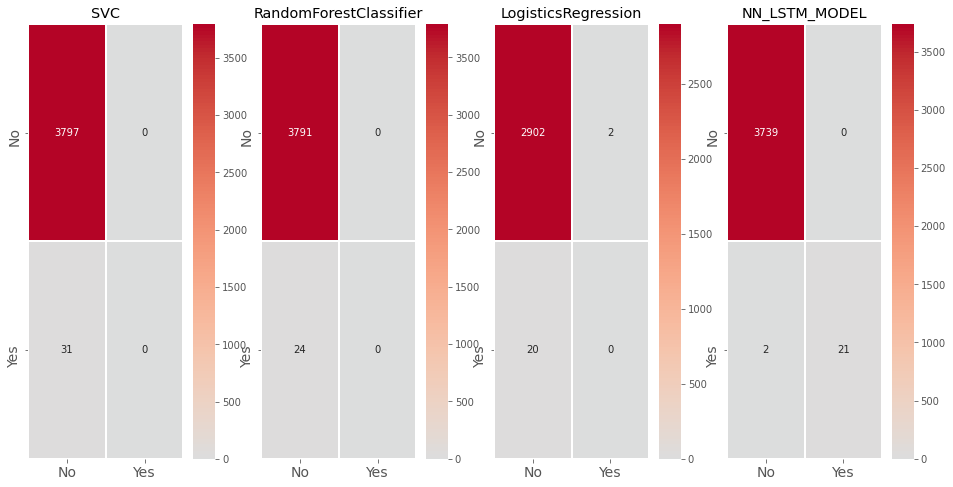

In [93]:
#Draw confusion matrix.
plotter.draw_cm_matrix(cm_dict, 1, 4)

In [94]:
#Trace Relsults.
metrics = plotter.writ_metrics_cm(cm_dict)
print(dfResult)
print ('\n')
print (metrics)

                     name  train_accuracy  ...  train_time(ms) pred_time(ms)
0                     SVC        0.470217  ...           83071          9166
1  RandomForestClassifier        0.549598  ...           10631           544
2     LogisticsRegression        0.416223  ...           28577           344
3           NN_LSTM_MODEL        0.922724  ...          564621          3200

[4 rows x 5 columns]


                   Method  recall  precison  specificity  f1_score
0                     SVC   0.000       NaN        1.000       NaN
1  RandomForestClassifier   0.000       NaN        1.000       NaN
2     LogisticsRegression   0.000       0.0        0.999       NaN
3           NN_LSTM_MODEL   0.913       1.0        1.000     0.955


In [95]:
#Print dataframe having results of all models.
dfResult

,name,train_accuracy,test_accuracy,train_time(ms),pred_time(ms)
0,SVC,0.470217,0.421176,83071,9166
1,RandomForestClassifier,0.549598,0.487059,10631,544
2,LogisticsRegression,0.416223,0.364706,28577,344
3,NN_LSTM_MODEL,0.922724,0.637647,564621,3200


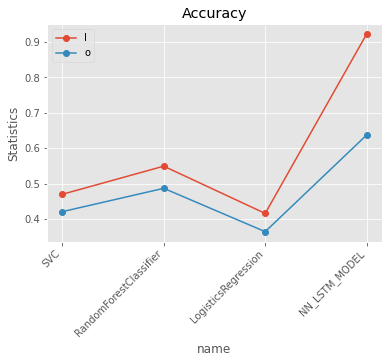

In [96]:
#Draw line chart comparing test and train accuracy of models.
plotter.draw_line_chart(dfResult, 'Accuracy','name', ['train_accuracy','test_accuracy'])

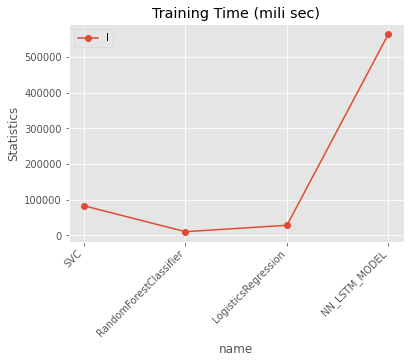

In [97]:
#Draw line chart comparing the training time of each model.
plotter.draw_line_chart(dfResult,'Training Time (mili sec)' ,'name', ['train_time(ms)'])

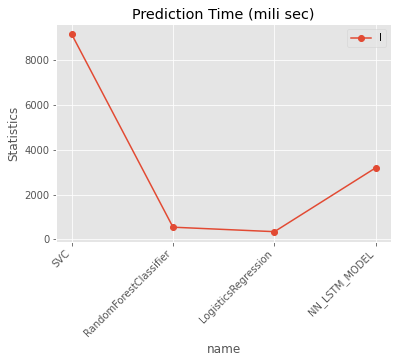

In [98]:
#compare prediction time on complete data of all models. 
plotter.draw_line_chart(dfResult,'Prediction Time (mili sec)' ,'name', ['pred_time(ms)'])